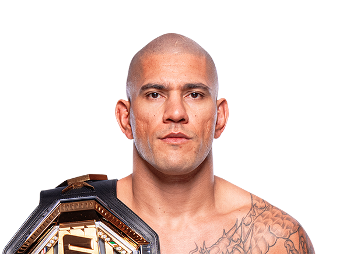

In [89]:
from PIL import Image

img = Image.open('images/poatan.png')
img

In [90]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /Users/ap/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-7-8 Python-3.10.14 torch-2.2.2 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [91]:
?model

Signature:       model(*args, **kwargs)
Type:            AutoShape
String form:    
AutoShape(
           (model): DetectMultiBackend(
           (model): DetectionModel(
           (model): Sequential( <...> 2): Conv2d(512, 255, kernel_size=(1, 1), stride=(1, 1))
           )
           )
           )
           )
           )
           )
File:            ~/.cache/torch/hub/ultralytics_yolov5_master/models/common.py
Docstring:       <no docstring>
Class docstring:
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.c

In [92]:
def object_detections(imgs: list) -> list:
    results = model(imgs)

    results.print()
    results.show()

    print(type(results))
    return results[0].pandas().xyxy


image 1/1: 254x350 1 person
Speed: 19.5ms pre-process, 192.9ms inference, 1.5ms NMS per image at shape (1, 3, 480, 640)


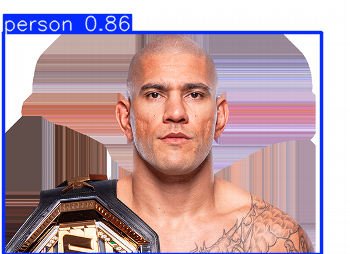

<class 'models.common.Detections'>


TypeError: 'Detections' object is not subscriptable

In [93]:
import pandas as pd

results_df = pd.DataFrame(object_detections([img]))

In [ ]:
results_df

[       xmin       ymin        xmax   ymax  confidence  class    name
 0  3.599482  32.844826  321.901215  254.0    0.858142      0  person]

In [ ]:
import cv2

In [ ]:
def video_to_frames(video_path: str) -> list:
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    frames = []
    while success:
        frames.append(image)
        success,image = vidcap.read()
        count += 1
    
    print(f"read {count} frames")
    
    return frames

In [ ]:
frames = video_to_frames("videos/psa.mp4")

read 3083 frames


image 1/10: 360x640 3 persons
image 2/10: 360x640 3 persons
image 3/10: 360x640 3 persons, 1 tennis racket
image 4/10: 360x640 3 persons, 2 tennis rackets
image 5/10: 360x640 3 persons, 2 tennis rackets
image 6/10: 360x640 3 persons, 2 tennis rackets
image 7/10: 360x640 3 persons, 2 tennis rackets
image 8/10: 360x640 3 persons, 1 tennis racket
image 9/10: 360x640 3 persons, 2 tennis rackets
image 10/10: 360x640 3 persons
Speed: 5.8ms pre-process, 145.0ms inference, 1.3ms NMS per image at shape (10, 3, 384, 640)


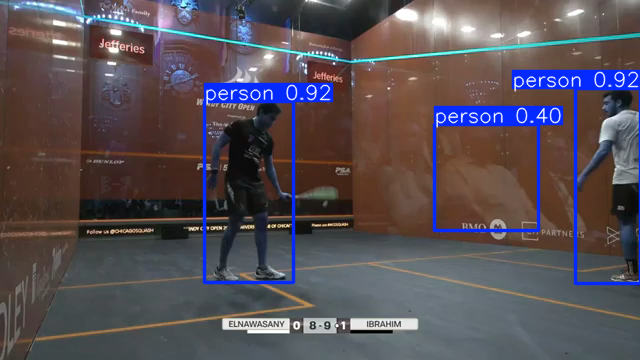

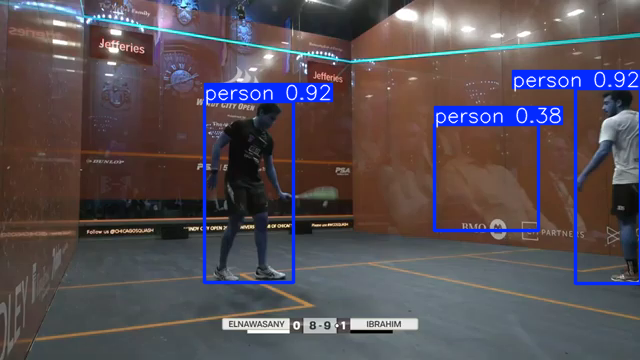

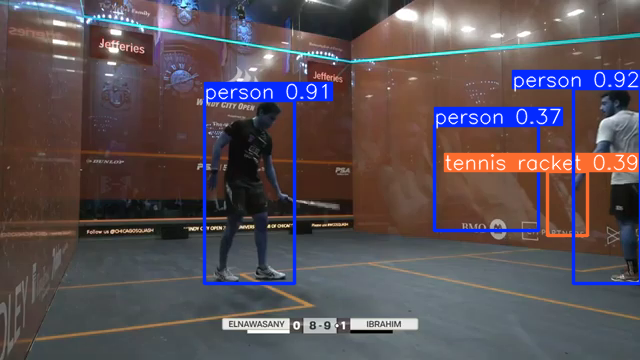

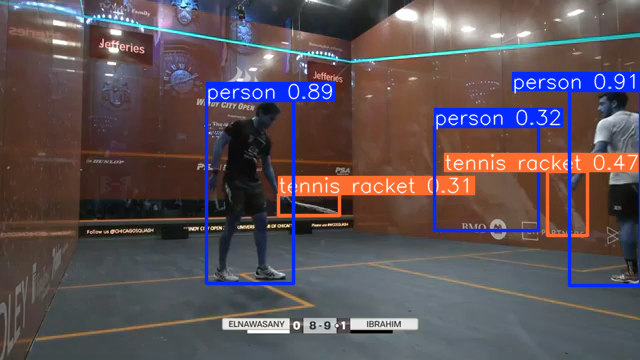

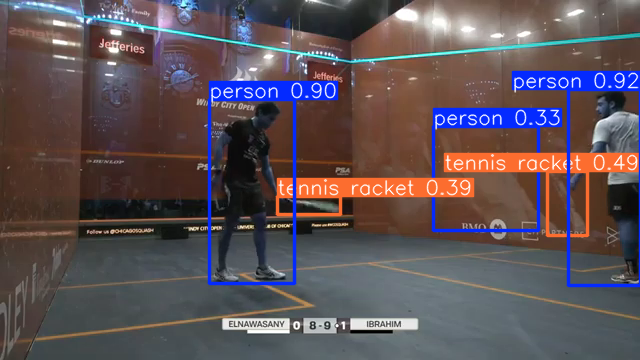

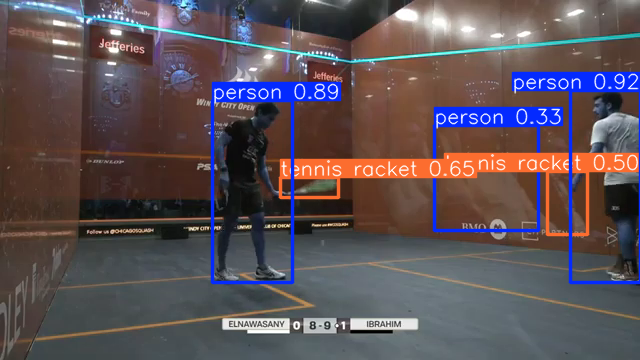

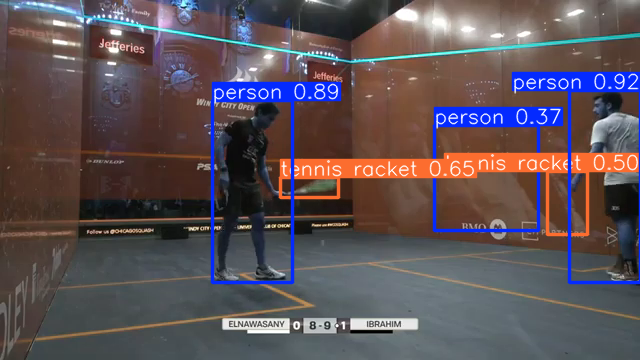

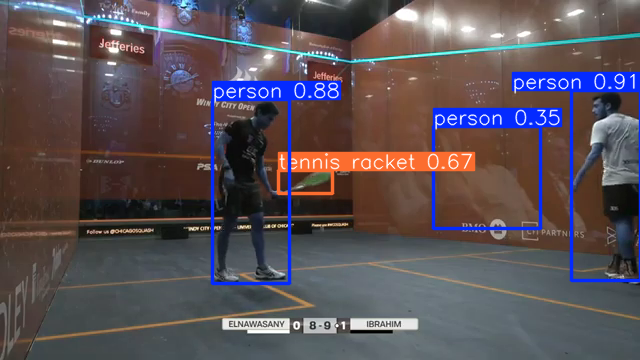

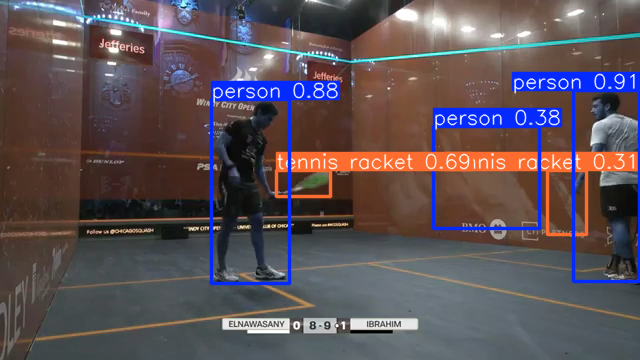

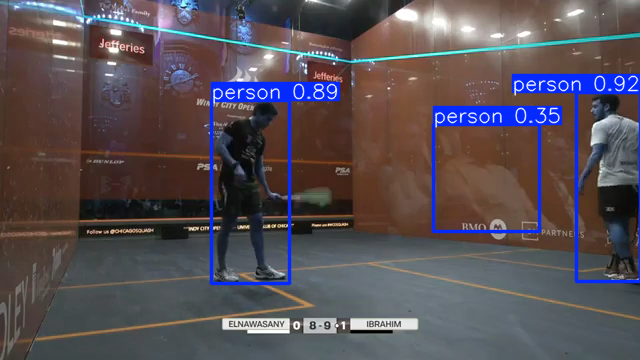

In [ ]:
results_df = pd.DataFrame(object_detections(frames[:10]))

In [ ]:
results_df

[         xmin        ymin        xmax        ymax  confidence  class    name
 0  575.004333   88.542992  640.000000  283.912903    0.924013      0  person
 1  204.784119  101.515762  293.296661  282.991455    0.916873      0  person
 2  434.161591  124.532669  538.565002  230.768509    0.396804      0  person,
          xmin        ymin        xmax        ymax  confidence  class    name
 0  575.060181   88.676811  640.000000  283.902771    0.924685      0  person
 1  204.769104  101.396004  293.345520  282.969666    0.917511      0  person
 2  434.321320  124.537247  538.100464  230.726578    0.384774      0  person,
          xmin        ymin        xmax        ymax  confidence  class  \
 0  573.217957   88.766266  640.000000  283.975037    0.921031      0   
 1  204.392502  100.983856  294.593231  283.026001    0.914887      0   
 2  547.584839  171.617874  587.651367  235.813766    0.388264     38   
 3  434.195526  125.532440  538.868225  230.649017    0.371934      0   
 
       

In [ ]:
type(results_df)

list

## YoLo v9

In [ ]:
import pandas as pd
from ultralytics import YOLO

model = YOLO("yolov9c.pt")

# Display model information (optional)
model.info()

YOLOv9c summary: 618 layers, 25590912 parameters, 0 gradients, 104.0 GFLOPs


(618, 25590912, 0, 104.02268160000003)

In [ ]:
results = model.predict([img])


0: 480x640 1 person, 1017.2ms
Speed: 17.9ms preprocess, 1017.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
type(results)

list

In [ ]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [ ]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.94430])
data: tensor([[  4.72167,  32.96918, 314.88031, 250.36861,   0.94430,   0.00000]])
id: None
is_track: False
orig_shape: (254, 350)
shape: torch.Size([1, 6])
xywh: tensor([[159.80099, 141.66888, 310.15863, 217.39943]])
xywhn: tensor([[0.45657, 0.55775, 0.88617, 0.85590]])
xyxy: tensor([[  4.72167,  32.96918, 314.88031, 250.36861]])
xyxyn: tensor([[0.01349, 0.12980, 0.89966, 0.98570]])

In [98]:
import json
detections_per_frame = [json.loads(result.tojson()) for result in results]

In [99]:
detections_per_frame

[[{'name': 'person',
   'class': 0,
   'confidence': 0.9443,
   'box': {'x1': 4.72167, 'y1': 32.96918, 'x2': 314.88031, 'y2': 250.36861}}]]

In [94]:
results[0].show()

In [ ]:
?model.predict

Signature:
model.predict(
    source: Union[str, pathlib.Path, int, list, tuple, numpy.ndarray, torch.Tensor] = None,
    stream: bool = False,
    predictor=None,
    **kwargs,
) -> List[ultralytics.engine.results.Results]
Docstring:
Performs predictions on the given image source using the YOLO model.

This method facilitates the prediction process, allowing various configurations through keyword arguments.
It supports predictions with custom predictors or the default predictor method. The method handles different
types of image sources and can operate in a streaming mode. It also provides support for SAM-type models
through 'prompts'.

The method sets up a new predictor if not already present and updates its arguments with each call.
It also issues a warning and uses default assets if the 'source' is not provided. The method determines if it
is being called from the command line interface and adjusts its behavior accordingly, including setting defaults
for confidence threshold and sa

In [ ]:
results?

Type:        list
String form:
[ultralytics.engine.results.Results object with attributes:
           
           boxes: ultralytics.engine.results.Bo <...> process': 17.86017417907715, 'inference': 1017.2019004821777, 'postprocess': 1.1019706726074219}]
Length:      1
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.